In [276]:
import numpy as np
import torch
import pygame
from torch import nn
from matplotlib import pyplot as plt
from os import listdir
from random import shuffle, random

In [377]:
# init device and discriminator
device = 'cuda' if torch.cuda.is_available() else 'cpu'

discriminator = nn.Sequential(
    nn.Conv2d(3, 8, 3, 1, 1),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(8, 16, 3, 1, 1),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(16, 32, 3, 1, 1),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(32, 64, 3, 1, 1),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(64, 128, 3, 1, 1),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(128, 256, 3, 1, 1),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(256, 64, 1),
    nn.ReLU(),

    nn.Conv2d(64, 16, 1),
    nn.ReLU(),

    nn.Conv2d(16, 1, 1),
    nn.Sigmoid()
).to(device)

# init loss criterion and optimizer for discriminator
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(discriminator.parameters(), lr=3e-4)

In [370]:
# load images
def imread(n=16):
    filenames = listdir('data')
    shuffle(filenames)
    return [pygame.image.load(f'data/{filename}') for filename in filenames[:n]]

In [372]:
def ruined_samples(images):
    # makes some samples bad
    imgs = []
    quality = []
    n = len(images)
    for i, k, img in zip(range(n), np.linspace(0, 1, n), images):
        sz, ns = int(1 + 63 * k), 2 * (1 - k)
        
        # blur image
        img = pygame.transform.smoothscale(pygame.transform.smoothscale(img, (sz, sz)), (64, 64))
        img = torch.tensor(pygame.surfarray.array3d(img).transpose(2, 0, 1) / 255)
        
        # add noise
        img = img + (np.random.rand(*img.shape) - 0.5) * ns
        img = torch.clamp(img, 0.0, 1.0)

        imgs.append(img)
        quality.append(k)
    return (torch.tensor(np.array(imgs), dtype=torch.float32).to(device),
            torch.tensor(quality, dtype=torch.float32).to(device).reshape(n, 1, 1, 1))

In [373]:
images = imread(16)
images, quality = ruined_samples(images)

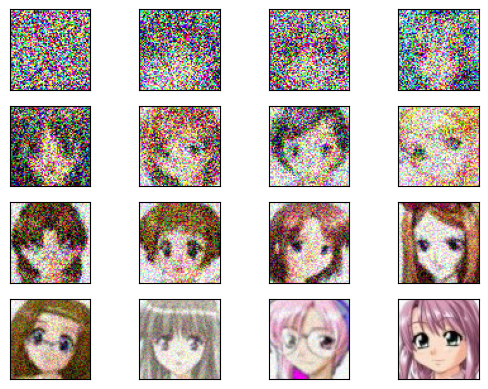

In [374]:
# show ruined images
w, h = 4, 4
results = images.to('cpu').detach().numpy().transpose(0, 3, 2, 1)
for x in range(w):
    for y in range(h):
        plt.subplot(h, w, x * h + y + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(results[x * h + y])

In [378]:
# train discriminator
for epoch in range(30):
    losses = []
    for _ in range(25):
        images = imread(64)
        images, quality = ruined_samples(images)
        output = discriminator(images)
        loss = criterion(output, quality)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch + 1}, Loss:{sum(losses) / len(losses)}')

Epoch:1, Loss:0.08487634986639023
Epoch:2, Loss:0.055989001244306565
Epoch:3, Loss:0.012741685714572668
Epoch:4, Loss:0.0026315181283280255
Epoch:5, Loss:0.002109448043629527
Epoch:6, Loss:0.0017817318020388485
Epoch:7, Loss:0.0015852372162044048
Epoch:8, Loss:0.001599016487598419
Epoch:9, Loss:0.0015643994649872184
Epoch:10, Loss:0.0014320226246491074
Epoch:11, Loss:0.0014291882701218128
Epoch:12, Loss:0.0012804594403132796
Epoch:13, Loss:0.001447272985242307
Epoch:14, Loss:0.0015519148344174027
Epoch:15, Loss:0.001953692678362131
Epoch:16, Loss:0.001315356029663235
Epoch:17, Loss:0.0010043475800193846
Epoch:18, Loss:0.0010632550809532404
Epoch:19, Loss:0.0008352916501462459
Epoch:20, Loss:0.0009221810358576477
Epoch:21, Loss:0.0008634600834921002
Epoch:22, Loss:0.0009611678053624928
Epoch:23, Loss:0.0008676314097829163
Epoch:24, Loss:0.001288794707506895
Epoch:25, Loss:0.0007985800923779607
Epoch:26, Loss:0.0008145842235535383
Epoch:27, Loss:0.0008573888777755201
Epoch:28, Loss:0.001

In [364]:
def mutated(gens, p, n=100, k=1):
    # roulette wheel choice
    i = list(range(len(p)))
    gens = gens[np.random.choice(i, n, p=p)]
    # add noise to chosen gens
    return torch.clamp(gens + (torch.rand(gens.shape) - 0.5) * k, 0.0, 1.0)


def crossover(gens, p, n=100):
    # roulette wheel choice
    i = list(range(len(p)))
    p1 = gens[np.random.choice(i, n, p=p)]
    p2 = gens[np.random.choice(i, n, p=p)]
    # new crossovered gens
    new = []
    for i in range(n):
        j = int(random() * 64)
        if round(random()):
            new.append(torch.concat((p1[i][:, :j, :], p2[i][:, j:, :]), 1))
        else:
            new.append(torch.concat((p1[i][:, :, :j], p2[i][:, :, j:]), 2))
    new = torch.tensor(np.array(new))
    return new


def fit(gens):
    # find fit for gens
    return discriminator(gens).reshape(-1)

In [365]:
gens = torch.rand((300, 3, 64, 64)).to(device)

In [366]:
# best gen fit
best = 0
# mutation rate
k = 2

In [367]:
while True:
    last_best = best
    # find fit
    fits = fit(gens)
    arr = [(ft.item(), gen) for ft, gen in zip(fits, gens)]
    # sort and remove worst 200 gens
    arr = sorted(arr, key=lambda x: x[0], reverse=True)[:100]
    best = max(best, arr[0][0])
    gens = torch.tensor(np.array([i.to('cpu').detach().numpy() for _, i in arr]), dtype=torch.float32)
    # probabilities, based on fit
    p = np.array([i for i, _ in arr])
    p /= p.sum()
    # mutated gens
    mutates = mutated(gens, p, 100, k=k)
    # crossover gens
    cross = crossover(gens, p, 100)
    
    gens = torch.concat((gens, mutates, cross)).to(device)
    print(best)
    # break the cycle
    if best > 0.8:
        break
    # update mutation rate if 
    if best == last_best:
        k = max(k * 0.99, 1e-3)
        print(f'{k = }')
# save image
img = arr[0][1].to('cpu').detach().numpy().transpose(1, 2, 0) * 255
img = pygame.surfarray.make_surface(img)
pygame.image.save(img, 'result.jpg')

0.4507799744606018
0.453800231218338
0.45650848746299744
0.45650848746299744
k = 1.98
0.4608621895313263
0.4648895263671875
0.466967910528183
0.4706781208515167
0.47205761075019836
0.4733484983444214
0.4733484983444214
k = 1.9602
0.4791148900985718
0.4791148900985718
k = 1.9405979999999998
0.4828658998012543
0.4834306240081787
0.49104049801826477
0.49104049801826477
k = 1.92119202
0.49104049801826477
k = 1.9019800997999998
0.49129512906074524
0.4957538843154907
0.4957538843154907
k = 1.8829602988019998
0.4961783289909363
0.4992208778858185
0.5006185173988342
0.5025925636291504
0.5041976571083069
0.5066401362419128
0.5110723376274109
0.5110723376274109
k = 1.8641306958139798
0.5122320055961609
0.5122320055961609
k = 1.84548938885584
0.5163094997406006
0.5163094997406006
k = 1.8270344949672814
0.5189000368118286
0.5193494558334351
0.5199912190437317
0.5208754539489746
0.5236008763313293
0.5236008763313293
k = 1.8087641500176086
0.5268303751945496
0.5281440615653992
0.5281440615653992
k =